In [2]:
library(Seurat)
library(tidyverse)
library(cowplot)
library(patchwork)
library(WGCNA)
library(ggplot2)
library(readxl)  # For reading Excel files
library(dplyr)


Loading required package: SeuratObject

Loading required package: sp


Attaching package: 'SeuratObject'


The following objects are masked from 'package:base':

    intersect, t


-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.1
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'cowplot'


The following object is masked from 'package:lubridate':

    stamp



Attaching package: 'patchwork'


The following object is masked from 'package:cowplot':

    align_plots


Loading required package: dynamicTreeCut

Loading required package: fastcluster


Att

Runing PCA

In [3]:
setwd("/Users/alicedecugis/Desktop/capstone")
wt1 <- Read10X(data.dir = "/Users/alicedecugis/Desktop/capstone/GSE178693_RAW/WT1")
wt2 <- Read10X(data.dir = "/Users/alicedecugis/Desktop/capstone/GSE178693_RAW/WT2")
mutant1 <- Read10X(data.dir = "/Users/alicedecugis/Desktop/capstone/GSE178693_RAW/Mutant1")
mutant2 <- Read10X(data.dir = "/Users/alicedecugis/Desktop/capstone/GSE178693_RAW/Mutant2")


In [4]:
wt1 <- CreateSeuratObject(counts = wt1, project = "Capstone",  min.cells = 3, min.features = 200)
wt2 <- CreateSeuratObject(counts = wt2, project = "Capstone",  min.cells = 3, min.features = 200)
mutant1 <- CreateSeuratObject(counts = mutant1, project = "Capstone",  min.cells = 3, min.features = 200)
mutant2 <- CreateSeuratObject(counts = mutant2, project = "Capstone",  min.cells = 3, min.features = 200)

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


Checks correct format

PCA 

In [5]:
pca_result_wt1 <- readRDS("/Users/alicedecugis/Desktop/capstone/pca_result.rds")
pca_result_wt2 <- readRDS("/Users/alicedecugis/Desktop/capstone/pca_result_wt2.rds")
pca_result_m1 <- readRDS("/Users/alicedecugis/Desktop/capstone/pca_result_m1.rds")
pca_result_m2 <- readRDS("/Users/alicedecugis/Desktop/capstone/pca_result_m2.rds")

marker_table <- read_excel("/Users/alicedecugis/Desktop/capstone/cell_types.xlsx", col_names = TRUE, skip = 1)
colnames(marker_table)

[1] "Astrocyte"       "Oligodendrocyte" "OPC"             "Microglia"      
 [5] "VLMC"            "Ependymal"       "Endothelial"     "Cholinergic"    
 [9] "GABAergic"       "Glutamatergic"   "Neuron"

In [6]:
head(marker_table)

Astrocyte,Oligodendrocyte,OPC,Microglia,VLMC,Ependymal,Endothelial,Cholinergic,GABAergic,Glutamatergic,Neuron
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1110054M08Rik,0610007P14Rik,Pdgfra,0610031J06Rik,Slc6a13,0610009L18Rik,1110008L16Rik,Nr4a2,Cwh43,Fat2,Fat2
2610017I09Rik,1110020A21Rik,Gm4876,1700017B05Rik,Slc6a20a,1110008J03Rik,1110034G24Rik,Cobll1,Nr4a2,Il16,Il16
2610100L16Rik,1110057K04Rik,Arhgap31,1810011H11Rik,Ranbp3l,1110017D15Rik,2810417H13Rik,Rxfp1,Oprk1,Gm2694,Gm2694
2900052N01Rik,1500004A13Rik,6030443J06Rik,4933406I18Rik,Aldh1a2,1700001O22Rik,4930594C11Rik,Dlc1,Ntng2,Cadps2,Cadps2
9630001P10Rik,1500015L24Rik,Sox6,5430427O19Rik,Col3a1,1700003E16Rik,5430416O09Rik,Etl4,Rxfp1,Adamts18,Adamts18
Aass,1700001P01Rik,Epn2,6230400D17Rik,Igf2,1700003M02Rik,8430408G22Rik,Gpr123,Cntnap3,Grm4,Grm4


In [7]:
# Combine PCA results into a list
pca_list <- list(
  wt1 = pca_result_wt1,
  wt2 = pca_result_wt2,
  m1  = pca_result_m1,
  m2  = pca_result_m2
)

# Extract only PC1 and PC2 from each PCA result
pca_numeric_list <- lapply(pca_list, function(pca_obj) pca_obj$x[, c("PC1", "PC2")])

# Extract individual results if needed
pca_result_wt1_numeric <- pca_numeric_list$wt1
pca_result_wt2_numeric <- pca_numeric_list$wt2
pca_result_m1_numeric  <- pca_numeric_list$m1
pca_result_m2_numeric  <- pca_numeric_list$m2

PCA k-means

Warning message:
"did not converge in 10 iterations"


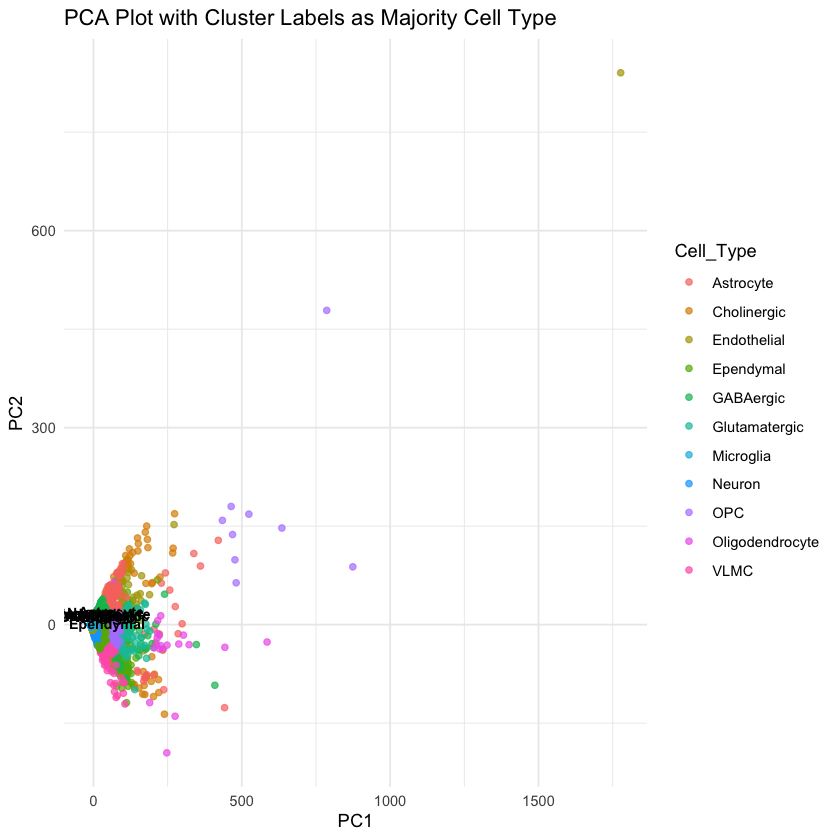

In [8]:
process_pca <- function(pca_result, dataset_name) {
  # Create PCA dataframe with first 2 PCs
  pca_df <- data.frame(PC1 = pca_result$x[,1], 
                       PC2 = pca_result$x[,2])
  
  # Perform k-means clustering (assume 11 clusters)
  set.seed(123)
  kmeans_result <- kmeans(pca_df, centers = 11)
  
  # Add cluster assignments
  pca_df$Cluster <- as.factor(kmeans_result$cluster)
  
  # Assign cell type labels based on dominant markers
  pca_df$Cell_Type <- case_when(
    pca_df$Cluster == 1 ~ "Astrocyte",
    pca_df$Cluster == 2 ~ "Oligodendrocyte",
    pca_df$Cluster == 3 ~ "OPC",
    pca_df$Cluster == 4 ~ "Microglia",
    pca_df$Cluster == 5 ~ "VLMC",
    pca_df$Cluster == 6 ~ "Ependymal",
    pca_df$Cluster == 7 ~ "Endothelial",
    pca_df$Cluster == 8 ~ "Cholinergic",
    pca_df$Cluster == 9 ~ "GABAergic",
    pca_df$Cluster == 10 ~ "Glutamatergic",
    pca_df$Cluster == 11 ~ "Neuron",
    TRUE ~ "Unknown"
  )
  
  # Add dataset name column
  pca_df$Dataset <- dataset_name
  
  return(pca_df)
}

# Process all PCA datasets and combine into one dataframe
combined_pca_df <- bind_rows(
  process_pca(pca_result_wt1, "WT1"),
  process_pca(pca_result_wt2, "WT2"),
  process_pca(pca_result_m1, "M1"),
  process_pca(pca_result_m2, "M2")
)

# Find the most common cell type in each cluster
cluster_labels <- combined_pca_df %>%
  group_by(Cluster, Cell_Type) %>%
  summarize(count = n(), .groups = 'drop') %>%
  arrange(Cluster, desc(count)) %>%
  distinct(Cluster, .keep_all = TRUE) %>%
  select(Cluster, Cell_Type)

# Merge the labels back into the PCA dataframe
combined_pca_df <- combined_pca_df %>%
  left_join(cluster_labels, by = "Cluster", suffix = c("", "_Majority"))

# Calculate centroids for each cluster
centroids_df <- combined_pca_df %>%
  group_by(Cluster, Cell_Type_Majority) %>%
  summarize(centroid_PC1 = mean(PC1), centroid_PC2 = mean(PC2), .groups = 'drop')

# Plot with cluster labels as the most common cell type
ggplot(combined_pca_df, aes(x = PC1, y = PC2, color = Cell_Type)) +
  geom_point(alpha = 0.7) +
  geom_text(data = centroids_df, aes(x = centroid_PC1, y = centroid_PC2, label = Cell_Type_Majority), 
            size = 3, fontface = "bold", color = "black", hjust = 0.5, vjust = -0.5) +
  labs(title = "PCA Plot with Cluster Labels as Majority Cell Type", x = "PC1", y = "PC2") +
  theme_minimal() +
  theme(legend.position = "right")

Runing UMAP

In [11]:
setwd("/Users/alicedecugis/Desktop/capstone")
wt1 <- Read10X(data.dir = "/Users/alicedecugis/Desktop/capstone/GSE178693_RAW/WT1")
wt2 <- Read10X(data.dir = "/Users/alicedecugis/Desktop/capstone/GSE178693_RAW/WT2")
mutant1 <- Read10X(data.dir = "/Users/alicedecugis/Desktop/capstone/GSE178693_RAW/Mutant1")
mutant2 <- Read10X(data.dir = "/Users/alicedecugis/Desktop/capstone/GSE178693_RAW/Mutant2")

wt1 <- CreateSeuratObject(counts = wt1, project = "Capstone",  min.cells = 3, min.features = 200)
wt2 <- CreateSeuratObject(counts = wt2, project = "Capstone",  min.cells = 3, min.features = 200)
mutant1 <- CreateSeuratObject(counts = mutant1, project = "Capstone",  min.cells = 3, min.features = 200)
mutant2 <- CreateSeuratObject(counts = mutant2, project = "Capstone",  min.cells = 3, min.features = 200)

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


In [12]:
# Normalize the data
wt1 <- NormalizeData(wt1)
wt2 <- NormalizeData(wt2)
mutant1 <- NormalizeData(mutant1)
mutant2 <- NormalizeData(mutant2)

# Find variable features
wt1 <- FindVariableFeatures(wt1)
wt2 <- FindVariableFeatures(wt2)
mutant1 <- FindVariableFeatures(mutant1)
mutant2 <- FindVariableFeatures(mutant2)

# Optionally, merge the datasets
combined <- merge(wt1, y = c(wt2, mutant1, mutant2), add.cell.ids = c("WT1", "WT2", "Mutant1", "Mutant2"))

# Scale the data and run PCA
combined <- ScaleData(combined)
combined <- RunPCA(combined)

# Run UMAP
combined <- RunUMAP(combined, reduction = "pca", dims = 1:30)

# Visualize the UMAP
#DimPlot(combined, reduction = "umap", group.by = "orig.ident")


Normalizing layer: counts

Normalizing layer: counts

Normalizing layer: counts

Normalizing layer: counts

Finding variable features for layer counts

Finding variable features for layer counts

Finding variable features for layer counts

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  Prph, Spock2, Snhg11, Ebf1, Akap12, Uchl1, Lrba, Bsg, Rgs4, Dgkh 
	   Tmsb10, Rbms1, Stmn2, Anxa2, Ly6c1, Flt1, Ppp1r1c, Scn9a, Gpr116, Pirt 
	   Abcb1a, Ywhah, Pcp4l1, Ly6a, Apold1, Slc17a6, Slco1a4, Gm26871, Ablim1, Tshz2 
Negative:  Ptgds, Enpp2, mt-Tv, Apod, mt-Tm, mt-Th, Mpz, mt-Tf, mt-Tc, Prx 
	   Gfap, 9430041J12Rik, Ctss, Edil3, Rdh5, P2ry12, Csf1r, Ttr, C1qb, Scg3 
	   Cst3, Selplg, Cx3cr1, Siglech, Ogn, Col9a3, C1qa, Laptm5, Ccl3, Lpar1 
PC_ 2 
Positive:  Flt1, Ly6c1, Ly6a, Slco1a4, Abcb1a, Apold1, Gpr116, Itm2a, Klf2, Slco1c1 
	   Igfbp7, Eltd1, Rgs5, Ptprb, Ly6e, Ly6c2, Id1, Abcg2, Palmd, Sdpr 
	   9430020K01Rik, Bsg, Slc2a1, Egfl7, Cldn5, Klf

UMAP k-means clustering 

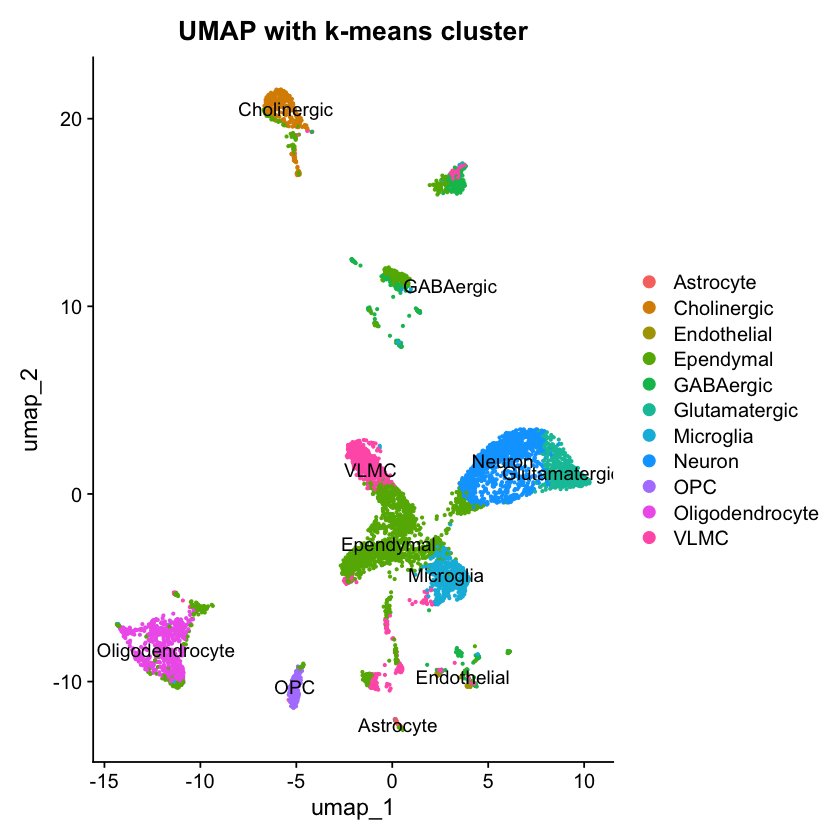

In [22]:
# Extract PCA embeddings
pca_embeddings <- Embeddings(combined, reduction = "pca")

# Perform k-means clustering (choose the number of clusters, e.g., k = 4)
set.seed(123)  # For reproducibility
kmeans_result <- kmeans(pca_embeddings, centers = 11)

# Add the k-means clusters to the metadata
combined$kmeans_clusters <- as.factor(kmeans_result$cluster)

# Assign cell type labels based on k-means cluster IDs
combined$cell_type <- case_when(
  combined$kmeans_clusters == 1 ~ "Neuron",
  combined$kmeans_clusters == 2 ~ "Oligodendrocyte",
  combined$kmeans_clusters == 3 ~ "GABAergic",
  combined$kmeans_clusters == 4 ~ "Astrocyte",
  combined$kmeans_clusters == 5 ~ "Endothelial",
  combined$kmeans_clusters == 6 ~ "Glutamatergic",
  combined$kmeans_clusters == 7 ~ "Ependymal",
  combined$kmeans_clusters == 8 ~ "Microglia",
  combined$kmeans_clusters == 9 ~ "VLMC",
  combined$kmeans_clusters == 10 ~ "Cholinergic",
  combined$kmeans_clusters == 11 ~ "OPC",
  TRUE ~ "Unknown"
)

# Visualize the clusters with cell type labels (based on your custom "cell_type" column) in the UMAP plot
DimPlot(combined, reduction = "umap", group.by = "cell_type", label = TRUE, pt.size = 0.5) + 
  ggtitle("UMAP with k-means cluster")


UMAP + louvain

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6481
Number of edges: 243656

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9524
Number of communities: 11
Elapsed time: 0 seconds


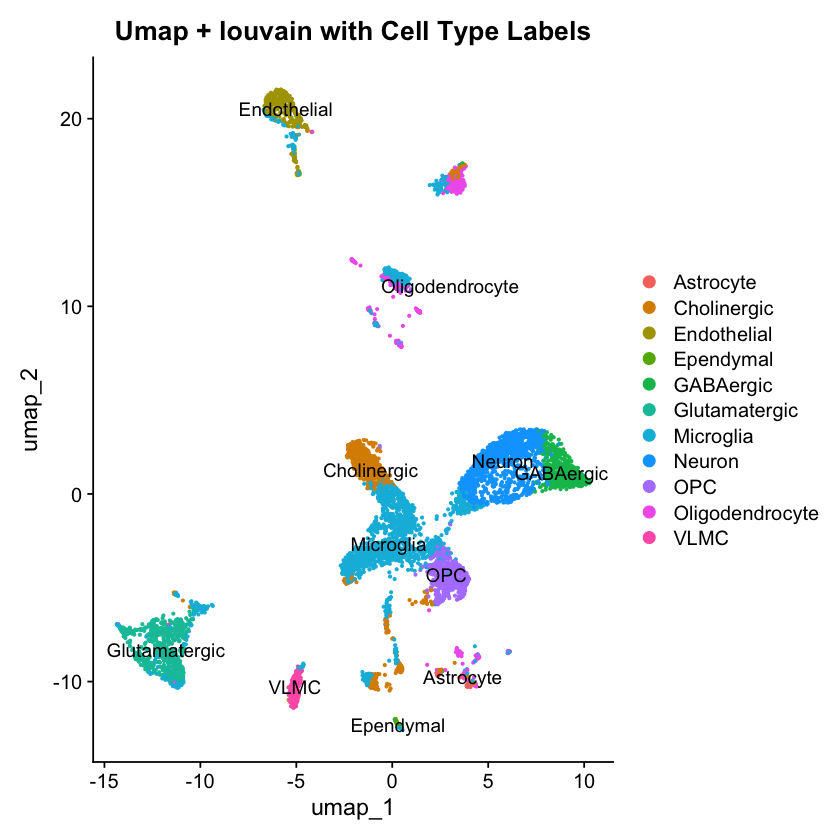

In [25]:
# Find neighbors (based on PCA or other reduced dimensions)
combined <- FindNeighbors(combined, dims = 1:20)  # Adjust the number of dimensions as needed

# Perform Louvain clustering (using the default resolution)
combined <- FindClusters(combined, resolution = 0.225)  # Adjust resolution as needed

# Assign cell type labels based on k-means cluster IDs
combined$cell_type <- case_when(
  combined$kmeans_clusters == 1 ~ "Neuron",
  combined$kmeans_clusters == 2 ~ "Glutamatergic",
  combined$kmeans_clusters == 3 ~ "Oligodendrocyte",
  combined$kmeans_clusters == 4 ~ "Ependymal",
  combined$kmeans_clusters == 5 ~ "Astrocyte",
  combined$kmeans_clusters == 6 ~ "GABAergic",
  combined$kmeans_clusters == 7 ~ "Microglia",
  combined$kmeans_clusters == 8 ~ "OPC",
  combined$kmeans_clusters == 9 ~ "Cholinergic",
  combined$kmeans_clusters == 10 ~ "Endothelial",
  combined$kmeans_clusters == 11 ~ "VLMC",
  TRUE ~ "Unknown"
)

# Visualize the clusters with cell type labels in the t-SNE plot
DimPlot(combined, reduction = "umap", group.by = "cell_type", label = TRUE, pt.size = 0.5) + 
  ggtitle("Umap + louvain with Cell Type Labels")


Running t-SNE

In [26]:
setwd("/Users/alicedecugis/Desktop/capstone")
wt1 <- Read10X(data.dir = "/Users/alicedecugis/Desktop/capstone/GSE178693_RAW/WT1")
wt2 <- Read10X(data.dir = "/Users/alicedecugis/Desktop/capstone/GSE178693_RAW/WT2")
mutant1 <- Read10X(data.dir = "/Users/alicedecugis/Desktop/capstone/GSE178693_RAW/Mutant1")
mutant2 <- Read10X(data.dir = "/Users/alicedecugis/Desktop/capstone/GSE178693_RAW/Mutant2")

wt1 <- CreateSeuratObject(counts = wt1, project = "Capstone",  min.cells = 3, min.features = 200)
wt2 <- CreateSeuratObject(counts = wt2, project = "Capstone",  min.cells = 3, min.features = 200)
mutant1 <- CreateSeuratObject(counts = mutant1, project = "Capstone",  min.cells = 3, min.features = 200)
mutant2 <- CreateSeuratObject(counts = mutant2, project = "Capstone",  min.cells = 3, min.features = 200)

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


In [35]:
# Combine all Seurat objects into one (optional, but makes analysis easier)
combined1 <- merge(wt1, y = c(wt2, mutant1, mutant2), add.cell.ids = c("WT1", "WT2", "Mutant1", "Mutant2"))

# Normalize the data
combined1 <- NormalizeData(combined)

# Find variable features
combined1 <- FindVariableFeatures(combined, selection.method = "vst", nfeatures = 2000)

# Scale the data
combined1 <- ScaleData(combined)

# Run PCA
combined1 <- RunPCA(combined, features = VariableFeatures(object = combined))

# Run t-SNE
combined1 <- RunTSNE(combined, dims = 1:20)
combined3 <- combined1

# Visualize t-SNE
head(combined1)
#DimPlot(combined1, reduction = "tsne", group.by = "orig.ident", label = TRUE, pt.size = 0.5) + ggtitle("t-SNE of Combined Data")

Normalizing layer: counts.1

Normalizing layer: counts.2

Normalizing layer: counts.3

Normalizing layer: counts.4

Finding variable features for layer counts.1

Finding variable features for layer counts.2

Finding variable features for layer counts.3

Finding variable features for layer counts.4

Centering and scaling data matrix

PC_ 1 
Positive:  Prph, Spock2, Snhg11, Ebf1, Akap12, Uchl1, Lrba, Bsg, Rgs4, Dgkh 
	   Tmsb10, Rbms1, Stmn2, Anxa2, Ly6c1, Flt1, Ppp1r1c, Scn9a, Gpr116, Pirt 
	   Abcb1a, Ywhah, Pcp4l1, Ly6a, Apold1, Slc17a6, Slco1a4, Gm26871, Ablim1, Tshz2 
Negative:  Ptgds, Enpp2, mt-Tv, Apod, mt-Tm, mt-Th, Mpz, mt-Tf, mt-Tc, Prx 
	   Gfap, 9430041J12Rik, Ctss, Edil3, Rdh5, P2ry12, Csf1r, Ttr, C1qb, Scg3 
	   Cst3, Selplg, Cx3cr1, Siglech, Ogn, Col9a3, C1qa, Laptm5, Ccl3, Lpar1 
PC_ 2 
Positive:  Flt1, Ly6c1, Ly6a, Slco1a4, Abcb1a, Apold1, Gpr116, Itm2a, Klf2, Slco1c1 
	   Igfbp7, Eltd1, Rgs5, Ptprb, Ly6e, Ly6c2, Id1, Abcg2, Palmd, Sdpr 
	   9430020K01Rik, Bsg, Slc2a1, E

,orig.ident,nCount_RNA,nFeature_RNA,kmeans_clusters,cell_type,RNA_snn_res.0.25,seurat_clusters,RNA_snn_res.0.225
,<chr>,<dbl>,<int>,<fct>,<chr>,<fct>,<fct>,<fct>
WT1_CTGGCTTCTGAG,Capstone,228245,12509,5,Endothelial,5,5,5
WT1_ACTCAACCCTCT,Capstone,208578,12112,5,Endothelial,5,5,5
WT1_GTCTCTACACTA,Capstone,166134,11168,5,Endothelial,5,5,5
WT1_GCCCGCTTGTTC,Capstone,152013,11149,5,Endothelial,5,5,5
WT1_AAAATGGTCTCA,Capstone,90549,10121,5,Endothelial,5,5,5
WT1_TATGATTTACAC,Capstone,80281,9700,5,Endothelial,5,5,5
WT1_AATTGCCTAACT,Capstone,48760,8350,5,Endothelial,5,5,5
WT1_CCAAGCATTAAC,Capstone,48713,8245,2,Oligodendrocyte,2,2,2
WT1_TGAACATTCTTT,Capstone,25544,5999,2,Oligodendrocyte,2,2,2


t-SNE + k-means (labels are arbitrary)

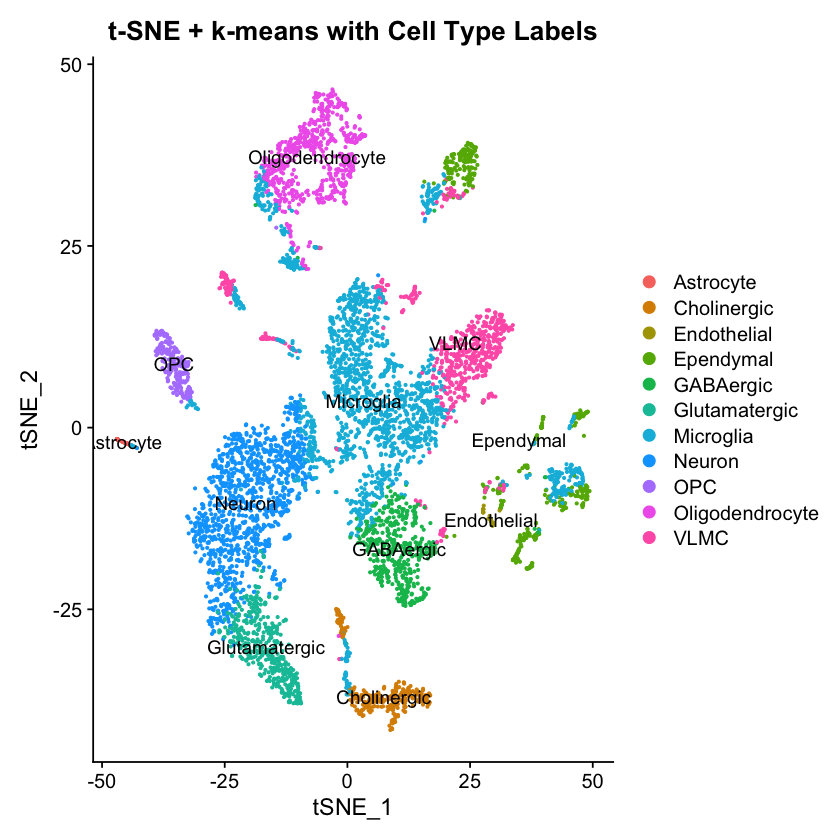

In [33]:
# Extract PCA or t-SNE embeddings for clustering (use t-SNE coordinates here)
tsne_embeddings <- Embeddings(combined1, reduction = "tsne")

# Perform k-means clustering (e.g., 4 clusters)
set.seed(123)
kmeans_result <- kmeans(tsne_embeddings, centers = 11)

# Add k-means clustering results to metadata
combined1$kmeans_clusters <- as.factor(kmeans_result$cluster)

# Assign cell type labels based on k-means cluster IDs
combined1$cell_type <- case_when(
  combined$kmeans_clusters == 1 ~ "Neuron",
  combined$kmeans_clusters == 2 ~ "Oligodendrocyte",
  combined$kmeans_clusters == 3 ~ "Ependymal",
  combined$kmeans_clusters == 4 ~ "Astrocyte",
  combined$kmeans_clusters == 5 ~ "Endothelial",
  combined$kmeans_clusters == 6 ~ "Glutamatergic",
  combined$kmeans_clusters == 7 ~ "Microglia",
  combined$kmeans_clusters == 8 ~ "GABAergic",
  combined$kmeans_clusters == 9 ~ "VLMC",
  combined$kmeans_clusters == 10 ~ "Cholinergic",
  combined$kmeans_clusters == 11 ~ "OPC",
  TRUE ~ "Unknown"
)

# Visualize the clusters with cell type labels in the t-SNE plot
DimPlot(combined1, reduction = "tsne", group.by = "cell_type", label = TRUE, pt.size = 0.5) + 
  ggtitle("t-SNE + k-means with Cell Type Labels")

t-SNE + louvain

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6481
Number of edges: 243656

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9490
Number of communities: 12
Elapsed time: 0 seconds


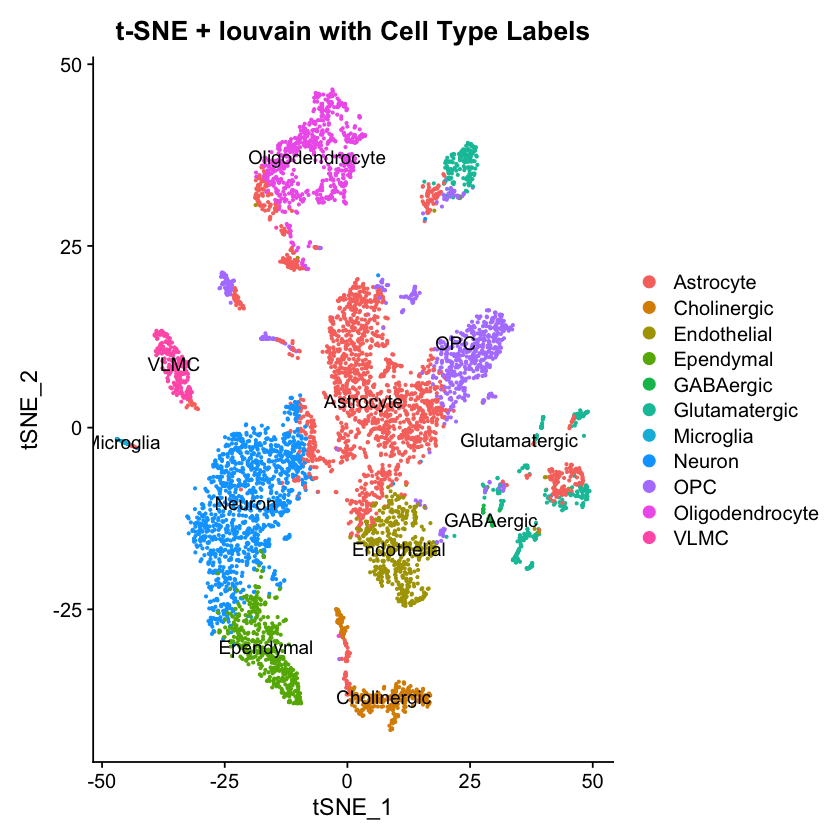

In [43]:
# Find neighbors (based on PCA or other reduced dimensions)
combined3 <- FindNeighbors(combined3, dims = 1:20)

# Perform Louvain clustering (using the default resolution)
combined3 <- FindClusters(combined3, resolution = 0.25)  # Adjust resolution as needed

combined3$cell_type <- case_when(
  combined$kmeans_clusters == 1 ~ "Neuron",
  combined$kmeans_clusters == 2 ~ "Oligodendrocyte",
  combined$kmeans_clusters == 3 ~ "Glutamatergic",
  combined$kmeans_clusters == 4 ~ "Microglia",
  combined$kmeans_clusters == 5 ~ "GABAergic",
  combined$kmeans_clusters == 6 ~ "Ependymal",
  combined$kmeans_clusters == 7 ~ "Astrocyte",
  combined$kmeans_clusters == 8 ~ "Endothelial",
  combined$kmeans_clusters == 9 ~ "OPC",
  combined$kmeans_clusters == 10 ~ "Cholinergic",
  combined$kmeans_clusters == 11 ~ "VLMC",
  TRUE ~ "Unknown"
)

# Visualize the clusters with cell type labels in the t-SNE plot
DimPlot(combined3, reduction = "tsne", group.by = "cell_type", label = TRUE, pt.size = 0.5) + 
  ggtitle("t-SNE + louvain with Cell Type Labels")
